In [1]:
import glob
import numpy as np
import pandas as pd
from flowio import FlowData
from sklearn.model_selection import train_test_split

def generate_column_dict(flow_data):
    i2s = dict()

    for i in flow_data.channels.keys():
        i2s[int(i)] = flow_data.channels[i]['PnS']
    
    i2s = {k: v for k, v in sorted(i2s.items(), key=lambda item: item[0])}
    print(f"Column Dictionary: {i2s}\n")
    return i2s

i2s = None
fcs_flist = [
    "./data/unscaled/Plate51_100_29_unstim_LiveLeukocytes.fcs",
    "./data/unscaled/Plate51_100_29_GMCSF_LiveLeukocytes.fcs",
    "./data/unscaled/Plate51_100_29_IFNa_LiveLeukocytes.fcs",
    "./data/unscaled/Plate51_100_29_IL246_LiveLeukocytes.fcs",
    "./data/unscaled/Plate51_100_29_LPS_LiveLeukocytes.fcs"
]

cond_dict = {
    0: "unstim",
    1: "GMCSF",
    2: "IFNa",
    3: "IL246",
    4: "LPS"
}
sample_points = 150000
dfs = []

for cond_idx, fcs_file_path in enumerate(fcs_flist):
    flow_data = FlowData(fcs_file_path)

    if i2s is None:
        i2s = generate_column_dict(flow_data)
    
    npy_data = np.reshape(flow_data.events, (-1, flow_data.channel_count))
    
    df = pd.DataFrame(npy_data, columns=list(i2s.values()))
    _, df_sample = train_test_split(df, test_size=sample_points, random_state=42, stratify=df['OmiqFilter'])
    df_sample.loc[:, "Y"] = cond_idx
    
    dfs.extend(df_sample.values.tolist())

dfs = pd.DataFrame(dfs, columns=list(i2s.values()) + ["Y"])
dfs

Column Dictionary: {1: '149Sm_CREB', 2: '150Nd_STAT5', 3: '151Eu_p38', 4: '153Eu_STAT1', 5: '154Sm_STAT3', 6: '155Gd_S6', 7: '156Gd_IkB', 8: '159Tb_MAPKAPK2', 9: '161Dy_cPARP', 10: '166Er_NFkB', 11: '167Er_ERK', 12: '168Er_STAT6', 13: 'OmiqFilter'}



,149Sm_CREB,150Nd_STAT5,151Eu_p38,153Eu_STAT1,154Sm_STAT3,155Gd_S6,156Gd_IkB,159Tb_MAPKAPK2,161Dy_cPARP,166Er_NFkB,167Er_ERK,168Er_STAT6,OmiqFilter,Y
0,0.028721,0.969324,0.000000,0.000000,1.072879,7.823342,5.549186,2.766168,0.000000,2.247436,6.952156,0.000000,15.0,0.0
1,0.000000,1.403413,0.694416,0.000000,21.292690,13.419436,4.234281,3.369319,4.630844,0.519319,0.000000,0.000000,7.0,0.0
2,0.000000,4.045133,1.660036,1.624906,0.922429,24.215569,4.224607,0.000000,0.000000,0.000000,0.253050,0.916919,7.0,0.0
3,0.452733,6.286063,0.000000,0.000000,0.000000,30.621368,4.081944,1.949453,1.314702,0.471009,1.842864,0.000000,7.0,0.0
4,0.000000,0.207857,0.000000,0.000000,0.000000,5.148047,2.861912,0.279663,6.961300,13.533669,2.363619,1.521376,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,3.130579,3.997771,6.900646,1.242984,3.066058,11.881989,0.000000,11.162114,0.540990,1.904705,0.000000,0.000000,7.0,4.0
749996,10.150041,3.569075,7.102046,1.791291,3.216087,22.052807,1.757832,7.656311,2.251803,1.130455,0.462008,0.000000,7.0,4.0
749997,4.273090,0.168717,7.000583,0.000000,2.411782,5.668507,0.000000,6.783205,0.000000,0.295004,0.000000,0.000000,7.0,4.0
749998,0.304803,0.763827,3.740746,3.201854,0.916115,28.276241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.0,4.0


In [2]:
import os
import pickle
from pycaret.classification import *

os.makedirs("./weights", exist_ok=True)

def get_feature_importance(best):
    feature_importances = {}
    for name, value in zip(best.feature_name_, best.feature_importances_):
        feature_importances[name] = value
    
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}
    
    return feature_importances

cond_of_interests_list = [
    [0, 1], [0, 2], [0, 3], [0, 4]
]

feature_importances = {}

In [3]:
# for cond_idx, cond_of_interests in enumerate(cond_of_interests_list):
cond_idx = 0
cond_of_interests = cond_of_interests_list[cond_idx]

df_of_interest = dfs[dfs.Y.isin(cond_of_interests)].reset_index(drop=True)
s = setup(df_of_interest, target='Y', session_id=42, categorical_features=["OmiqFilter"], normalize=True, fold=5)
model = create_model('lightgbm')
feature_importances[cond_idx] = get_feature_importance(model)

with open(f"./weights/lightgbm-{cond_of_interests[0]}-{cond_of_interests[1]}.pkl", "wb") as f:
    pickle.dump(model, f)

,Description,Value
0,Session id,42
1,Target,Y
2,Target type,Binary
3,Original data shape,"(300000, 14)"
4,Transformed data shape,"(300000, 33)"
5,Transformed train set shape,"(210000, 33)"
6,Transformed test set shape,"(90000, 33)"
7,Numeric features,12
8,Categorical features,1
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9445,0.9891,0.9890,0.9082,0.9469,0.8890,0.8925
1,0.9454,0.9897,0.9900,0.9088,0.9477,0.8907,0.8943
2,0.9421,0.9890,0.9891,0.9041,0.9447,0.8842,0.8881
3,0.9430,0.9893,0.9874,0.9069,0.9455,0.8861,0.8896
4,0.9444,0.9898,0.9888,0.9082,0.9468,0.8889,0.8924
Mean,0.9439,0.9894,0.9889,0.9072,0.9463,0.8878,0.8914
Std,0.0012,0.0003,0.0008,0.0017,0.0011,0.0023,0.0022


In [4]:
# for cond_idx, cond_of_interests in enumerate(cond_of_interests_list):
cond_idx = 1
cond_of_interests = cond_of_interests_list[cond_idx]

df_of_interest = dfs[dfs.Y.isin(cond_of_interests)].reset_index(drop=True)
s = setup(df_of_interest, target='Y', session_id=42, categorical_features=["OmiqFilter"], normalize=True, fold=5)
model = create_model('lightgbm')
feature_importances[cond_idx] = get_feature_importance(model)

with open(f"./weights/lightgbm-{cond_of_interests[0]}-{cond_of_interests[1]}.pkl", "wb") as f:
    pickle.dump(model, f)

,Description,Value
0,Session id,42
1,Target,Y
2,Target type,Binary
3,Target mapping,"0.0: 0, 2.0: 1"
4,Original data shape,"(300000, 14)"
5,Transformed data shape,"(300000, 33)"
6,Transformed train set shape,"(210000, 33)"
7,Transformed test set shape,"(90000, 33)"
8,Numeric features,12
9,Categorical features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9817,0.9970,0.9817,0.9818,0.9817,0.9634,0.9635
1,0.9830,0.9979,0.9830,0.9830,0.9830,0.9660,0.9660
2,0.9808,0.9972,0.9808,0.9809,0.9808,0.9616,0.9617
3,0.9811,0.9977,0.9811,0.9812,0.9811,0.9623,0.9624
4,0.9811,0.9975,0.9811,0.9811,0.9811,0.9621,0.9622
Mean,0.9815,0.9975,0.9815,0.9816,0.9815,0.9631,0.9631
Std,0.0008,0.0003,0.0008,0.0008,0.0008,0.0015,0.0015


In [5]:
# for cond_idx, cond_of_interests in enumerate(cond_of_interests_list):
cond_idx = 2
cond_of_interests = cond_of_interests_list[cond_idx]

df_of_interest = dfs[dfs.Y.isin(cond_of_interests)].reset_index(drop=True)
s = setup(df_of_interest, target='Y', session_id=42, categorical_features=["OmiqFilter"], normalize=True, fold=5)
model = create_model('lightgbm')
feature_importances[cond_idx] = get_feature_importance(model)

with open(f"./weights/lightgbm-{cond_of_interests[0]}-{cond_of_interests[1]}.pkl", "wb") as f:
    pickle.dump(model, f)

,Description,Value
0,Session id,42
1,Target,Y
2,Target type,Binary
3,Target mapping,"0.0: 0, 3.0: 1"
4,Original data shape,"(300000, 14)"
5,Transformed data shape,"(300000, 33)"
6,Transformed train set shape,"(210000, 33)"
7,Transformed test set shape,"(90000, 33)"
8,Numeric features,12
9,Categorical features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9848,0.9981,0.9848,0.9848,0.9848,0.9696,0.9696
1,0.9841,0.9980,0.9841,0.9842,0.9841,0.9683,0.9683
2,0.9855,0.9983,0.9855,0.9856,0.9855,0.9711,0.9711
3,0.9845,0.9981,0.9845,0.9845,0.9845,0.9689,0.9689
4,0.9852,0.9977,0.9852,0.9852,0.9852,0.9704,0.9704
Mean,0.9848,0.9981,0.9848,0.9849,0.9848,0.9696,0.9697
Std,0.0005,0.0002,0.0005,0.0005,0.0005,0.0010,0.0010


In [6]:
# for cond_idx, cond_of_interests in enumerate(cond_of_interests_list):
cond_idx = 3
cond_of_interests = cond_of_interests_list[cond_idx]

df_of_interest = dfs[dfs.Y.isin(cond_of_interests)].reset_index(drop=True)
s = setup(df_of_interest, target='Y', session_id=42, categorical_features=["OmiqFilter"], normalize=True, fold=5)
model = create_model('lightgbm')
feature_importances[cond_idx] = get_feature_importance(model)

with open(f"./weights/lightgbm-{cond_of_interests[0]}-{cond_of_interests[1]}.pkl", "wb") as f:
    pickle.dump(model, f)

,Description,Value
0,Session id,42
1,Target,Y
2,Target type,Binary
3,Target mapping,"0.0: 0, 4.0: 1"
4,Original data shape,"(300000, 14)"
5,Transformed data shape,"(300000, 33)"
6,Transformed train set shape,"(210000, 33)"
7,Transformed test set shape,"(90000, 33)"
8,Numeric features,12
9,Categorical features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9160,0.9780,0.9160,0.9180,0.9159,0.8320,0.8340
1,0.9167,0.9792,0.9167,0.9192,0.9165,0.8333,0.8358
2,0.9137,0.9777,0.9137,0.9161,0.9136,0.8275,0.8298
3,0.9171,0.9792,0.9171,0.9194,0.9170,0.8341,0.8364
4,0.9166,0.9784,0.9166,0.9188,0.9165,0.8332,0.8355
Mean,0.9160,0.9785,0.9160,0.9183,0.9159,0.8320,0.8343
Std,0.0012,0.0006,0.0012,0.0012,0.0012,0.0024,0.0024


In [7]:
# for cond_idx, cond_of_interests in enumerate(cond_of_interests_list):
cond_idx = 4
cond_of_interests = cond_of_interests_list[0]

df_of_interest = dfs[dfs.Y.isin(cond_of_interests)].reset_index(drop=True)
s = setup(df_of_interest, target='Y', session_id=42, categorical_features=["OmiqFilter"], normalize=True, fold=5)
model = create_model('lightgbm')
feature_importances[cond_idx] = get_feature_importance(model)

with open(f"./weights/lightgbm-{cond_of_interests[0]}-{cond_of_interests[1]}.pkl", "wb") as f:
    pickle.dump(model, f)

,Description,Value
0,Session id,42
1,Target,Y
2,Target type,Binary
3,Original data shape,"(300000, 14)"
4,Transformed data shape,"(300000, 33)"
5,Transformed train set shape,"(210000, 33)"
6,Transformed test set shape,"(90000, 33)"
7,Numeric features,12
8,Categorical features,1
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9445,0.9891,0.9890,0.9082,0.9469,0.8890,0.8925
1,0.9454,0.9897,0.9900,0.9088,0.9477,0.8907,0.8943
2,0.9421,0.9890,0.9891,0.9041,0.9447,0.8842,0.8881
3,0.9430,0.9893,0.9874,0.9069,0.9455,0.8861,0.8896
4,0.9444,0.9898,0.9888,0.9082,0.9468,0.8889,0.8924
Mean,0.9439,0.9894,0.9889,0.9072,0.9463,0.8878,0.8914
Std,0.0012,0.0003,0.0008,0.0017,0.0011,0.0023,0.0022


In [8]:
import matplotlib.pyplot as plt
from collections import defaultdict

data = defaultdict(list)

for i in range(5):
    for k, v in feature_importances[i].items():
        data[k].append(v)
        
feature_importance_df = pd.DataFrame(data)
mean_values = feature_importance_df.mean()

# Sort the DataFrame columns by mean values
sorted_columns = mean_values.sort_values(ascending=False).index
feature_importance_df = feature_importance_df[sorted_columns][:4]
feature_importance_df

,150Nd_STAT5,154Sm_STAT3,156Gd_IkB,159Tb_MAPKAPK2,155Gd_S6,168Er_STAT6,166Er_NFkB,151Eu_p38,149Sm_CREB,OmiqFilter_7.0,...,OmiqFilter_11.0,OmiqFilter_12.0,OmiqFilter_18.0,OmiqFilter_4.0,OmiqFilter_3.0,OmiqFilter_10.0,OmiqFilter_9.0,OmiqFilter_8.0,OmiqFilter_6.0,OmiqFilter_17.0
0,620,184,318,345,296,185,174,87,132,118,...,7,1,8,2,0,0,1,3,1,0
1,394,570,248,119,315,140,130,65,138,103,...,29,18,0,6,1,6,6,1,0,3
2,359,343,251,156,215,491,275,19,110,105,...,15,0,0,5,12,5,0,1,4,2
3,121,296,365,480,267,68,136,455,179,149,...,2,2,0,0,0,0,1,0,0,1


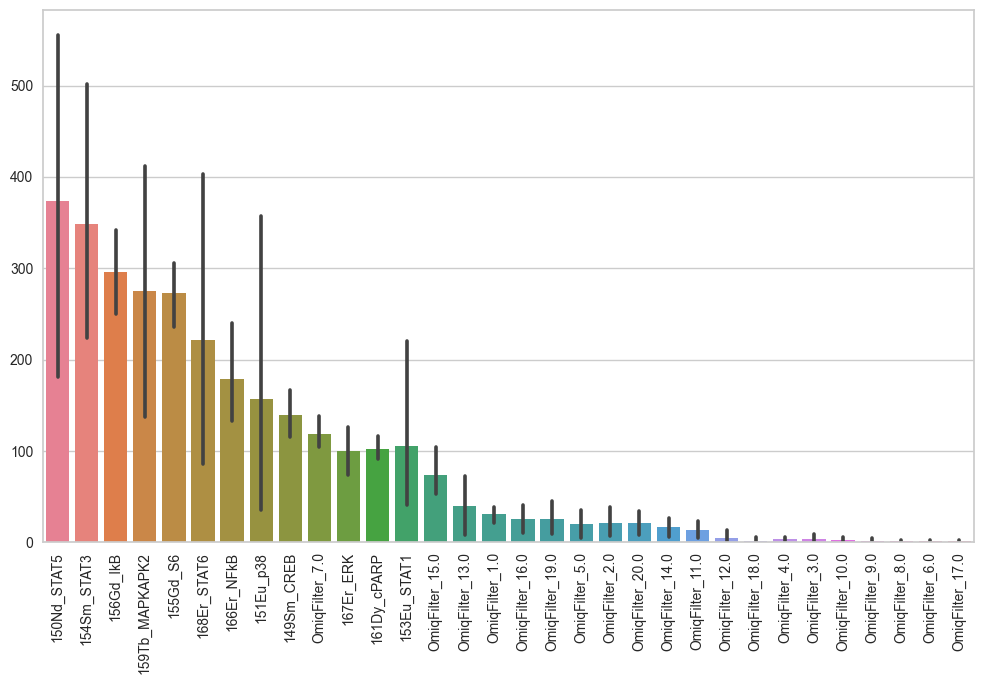

In [9]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.barplot(feature_importance_df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("./figures/feature_importance_barplot.png")
plt.show()

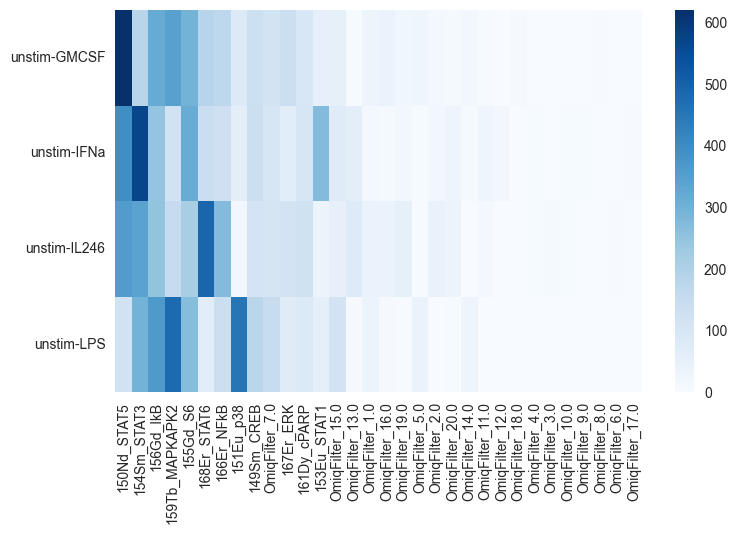

In [10]:
cond_dict = {
    0: "unstim",
    1: "GMCSF",
    2: "IFNa",
    3: "IL246",
    4: "LPS"
}

axis_names = []
for i in range(4):
    axis_name = f"{cond_dict[0]}-{cond_dict[i+1]}"
    axis_names.append(axis_name)
    
sns.heatmap(feature_importance_df, yticklabels=axis_names, cmap="Blues")
plt.yticks(rotation=00)
plt.tight_layout()
plt.savefig("./figures/feature_importance_heatmap.png")
plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

omiq_name_list = pd.read_csv("./data/scaled/_FilterValuesToNames.csv").iloc[:, 1].values.tolist()
cond_dict = {
    0: "unstim",
    1: "GMCSF",
    2: "IFNa",
    3: "IL246",
    4: "LPS"
}

plt.rcParams['savefig.facecolor'] = "0.5"

def generate_cell_type_specific_plot(dfs, cond_dict, cond_of_interest, marker, omiq_name_list):
    df_of_interest = dfs[dfs.Y.isin(cond_of_interest)].reset_index(drop=True)
    sampled = df_of_interest.loc[:, ["Y", "OmiqFilter", marker]]
    sns.set_theme()
    plt.figure(figsize=(20, 20))
    plt.suptitle(f"Cell type specific change of {marker}", fontsize=20, y=1.0)
    
    for omiq_idx in range(1, 21):
        plt.subplot(4, 5, omiq_idx)
        omiq_df = sampled[sampled.OmiqFilter == omiq_idx]
        col_name = omiq_df.columns[2]
        plt.title(omiq_name_list[omiq_idx - 1])
        
        sns.boxplot(omiq_df, x="Y", y=col_name, hue="Y", legend=False)
        plt.ylabel("")
        plt.xlabel("")
        plt.xticks([0, 1], [cond_dict[cond_of_interest[0]], cond_dict[cond_of_interest[1]]], fontsize=12)

    plt.tight_layout()
    plt.show()

generate_cell_type_specific_plot(dfs, cond_dict, cond_of_interest=[0, 4], marker="150Nd_STAT5", omiq_name_list=omiq_name_list)

In [12]:
def generate_cell_type_specific_heatmap(dfs, marker_list, omiq_name_list, output_file):
    plt.figure(figsize=(20, 25))
    # sns.set_theme(style='white')

    palette1 = plt.cm.twilight.colors  # Viridis palette
    
    for figure_index, marker in enumerate(marker_list):
        plt.subplot(4, 3, figure_index + 1)
        sampled = dfs.loc[:, ["Y", "OmiqFilter", marker]]
        
        mean_features = sampled.groupby(["Y", "OmiqFilter"]).mean().unstack(level=0).values
        base = mean_features[:, 0].reshape(-1, 1)
        
        mean_features -= np.repeat(base, 5, axis=1)
        v_min, v_max = mean_features.min(), mean_features.max()
        
        tau = max(-v_min, v_max)

        
        sns.heatmap(mean_features, annot=False, fmt=".2f", cmap="twilight", vmin=-tau, vmax=tau)
        plt.title(f"{marker}", fontsize=15)
        plt.yticks(list(np.arange(0.5, 20.5, 1)), omiq_name_list, rotation=00)
        plt.xticks(list(np.arange(0.5, 5.5, 1)), [x for x in cond_dict.values()])
    
    plt.tight_layout()
    plt.savefig(output_file, bbox_inches='tight')
    plt.close()

omiq_name_list = pd.read_csv("./data/scaled/_FilterValuesToNames.csv").iloc[:, 1].values.tolist()
marker_list = list(dfs.columns)[:-2]
generate_cell_type_specific_heatmap(dfs, marker_list=marker_list, omiq_name_list=omiq_name_list, output_file="./figures/cond_wise_heatmaps.png")

In [13]:
from fpdf import FPDF

# Create instance of FPDF class
pdf = FPDF()

figure_files = [
    ("./figures/feature_importance_barplot.png", "Feature Importance Bar Plot"),
    ("./figures/feature_importance_heatmap.png", "Feature Importance Heatmap"),
    ("./figures/cond_wise_heatmaps.png", "Condition-wise Heatmaps")
]

# Loop through figure files and add them to the PDF with text
for figure, title in figure_files:
    pdf.add_page()
    
    # Add title text
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt=title, ln=True, align='C')
    
    # Add the image
    pdf.image(figure, x=10, y=30, w=190)  # Adjust x, y, w for positioning and size

# Save the PDF
pdf.output("figures_with_text.pdf")
print()